In [2]:
import gym
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import json
from numpy import pi
import pickle
import matlab

from seagul.plot import smooth_bounded_curve
from bball3_env import BBall3Env
from bball3_mj_env import BBall3MJEnv
from bball3_pb_env import BBall3PBEnv

from stable_baselines import PPO2 as ALGO
from stable_baselines.results_plotter import load_results

import pybullet as p


env_name = "bball3_pb-v0"


def do_rollout_stable(init_point=None, render=False, video=False):
    #env = gym.make(env_name, **env_config)
    #env = BBall3Env(**env_config)
    #env = BBall3MJEnv()
    env = BBall3PBEnv()

    obs = env.reset()

    obs = torch.as_tensor(obs, dtype=torch.float32)

    acts_list = []
    obs1_list = []
    rews_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    while not done:
        acts = model.predict(obs)[0]
        obs, rew, done, out = env.step(acts)
          
            
        if render:
            env.render()
            time.sleep(.1)
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)
    
    env.close()

    return ep_obs1, ep_acts, ep_rews

/home/sgillen/work/seagul/seagul/envs/__init__.py:55: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")
/home/sgillen/work/seagul/seagul/envs/__init__.py:131: UserWarning: Warning, rllib environments not registered
  warnings.warn("Warning, rllib environments not registered")


running build_ext
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Loading a model without an environment, this model cannot be trained until it has a valid environment.





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


<Figure size 432x288 with 0 Axes>

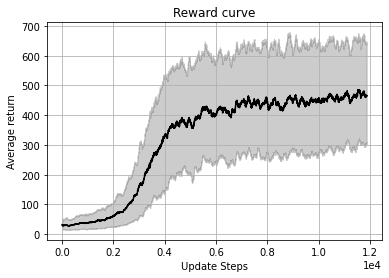

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
# %%
fig, ax = plt.subplots(1,1)

#log_dir = script_path + './walker_log'
df_list = []
model_list = []
min_length = float('inf')


# pybullet
p.connect(p.GUI)
#trial_path = "/home/sgillen/work/bball/python/data_ppo/t12"
trial_path = "/home/sgillen/work/bball/python/data_ppo/pb_strong0"


# mj paths
#trial_path = "/home/sgillen/work/bball/python/data_ppo/mj_apen2" # seed 0 bounces good

# matlab
#trial_path = "/home/sgillen/work/bball/python/data_ppo_wc/y_less_tall1"
#trial_path = "/home/sgillen/work/bball/python/data_ppo_wc/small_ypen"
#trial_path = "/home/sgillen/work/bball/data_ppo_wc/t2/"  # another balance, y rewards. 
#trial_path = "/home/sgillen/work/bball/data_ppo_wc/no_xpen/"  # another balance, y rewards. 
#trial_path = "/home/sgillen/work/bball/data_ppo_wc/0/"  # another balance, x an y rewards. 
#trial_path = "/home/sgillen/work/bball/data_ppo_nc/long_100"   # No y reward



def reward_fn(state, action):
    xpen = np.clip(-(state[3] - .15)**2, -1, 0)
    #xpen = 0.0

    ypen = np.clip(-(state[4] - 1.2)**2, -4, 0)
    #ypen = 0.0

    alive = 5.0
    return xpen + ypen + alive
  #  return -(state[4] - 1)**2 + alive


for entry in os.scandir(trial_path):
    if ".ipynb" in entry.path:
        continue
    if "config" in entry.path:
        env_config = pickle.load(open(entry.path, 'rb'))
        continue
    
    df = load_results(entry.path)


    if len(df['r']) < min_length:
        min_length = len(df['r'])

    #plt.plot(df['r'])
    plt.figure()
    df_list.append(df)
    model_list.append(ALGO.load(entry.path + "/model.zip"))

min_length = int(min_length)
rewards = np.zeros((min_length, len(df_list)))

for i, df in enumerate(df_list):
    rewards[:, i] = np.array(df['r'][:min_length])

smooth_bounded_curve(rewards[:min_length], ax=ax)
#ax.set_ylim(0,200)
 
ax.grid()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#fig.savefig(script_path + '../figs/reward.png')
plt.figure()

#env = BBall3Env(**env_config)
#p.connect(p.GUI)



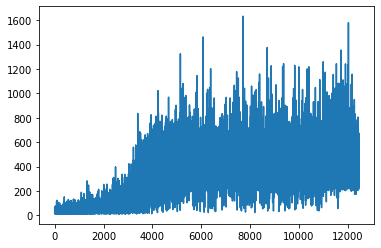

/home/sgillen/miniconda3/envs/matlab/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


reward sum: 604.1502075195312


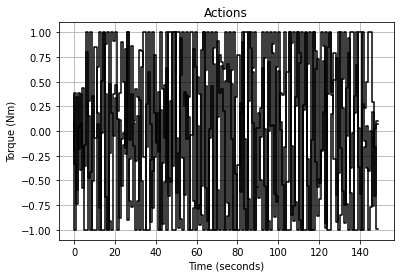

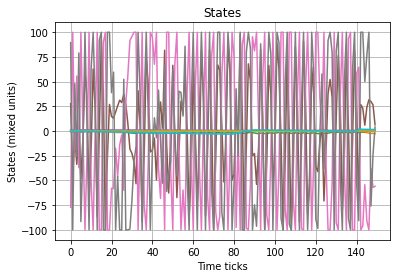

In [5]:
trial_num = 0

model = model_list[trial_num]
df = df_list[trial_num]
 
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist = do_rollout_stable(render=True)


print(f"reward sum: {sum(rew_hist)}")

plt.step([i for i in range(act_hist.shape[0])], act_hist, 'k')
plt.title('Actions')
plt.xlabel('Time (seconds)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States')
plt.xlabel('Time ticks')
plt.ylabel('States (mixed units)')
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.show()

In [41]:
env.eng.clf()
obs_list = []
for obs in obs_hist:
    obs_list.append(obs.tolist())
import matlab
tout = matlab.single([float(i) for i in range(obs_hist.shape[0])])
env.animate(tout,matlab.single(obs_list))

In [ ]:
print(sum(rew_hist))

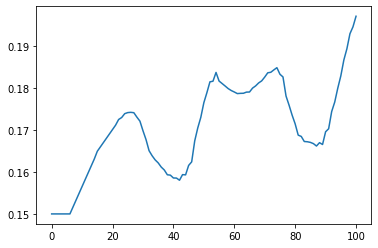

In [51]:
plt.plot(obs_hist[:,3])

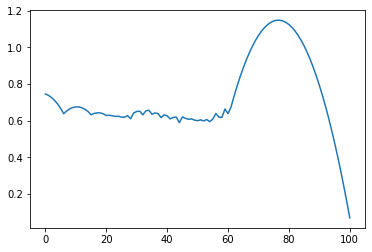

In [65]:
plt.plot(obs_hist[:,4])

In [ ]:
l = .3
plt.plot(l*np.sin(obs_hist[:,0]) + l*np.sin(obs_hist[:,1] + obs_hist[:,0]) + l*np.sin(obs_hist[:,2] + obs_hist[:,1] + obs_hist[:,0]))

In [ ]:
l = .3
plt.plot(l*np.cos(obs_hist[:,0]) + l*np.cos(obs_hist[:,1] + obs_hist[:,0]) + l*np.cos(obs_hist[:,2] + obs_hist[:,1] + obs_hist[:,0]))

In [30]:
model_name = input("model name?: ")
input(f"{model_name}, ok?")

model_path = f"/home/sgillen/work/bball/models/{model_name}"
os.makedirs(model_path)
model.save(f"{model_path}/model.zip")
pickle.dump(env_config, open(f"{model_path}/config.pkl", 'wb'))
print(f"model_path = \"{model_path}/model.zip\"")

KeyboardInterrupt: 

Loading a model without an environment, this model cannot be trained until it has a valid environment.


/home/sgillen/miniconda3/envs/matlab/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


reward sum: 100.67078399658203


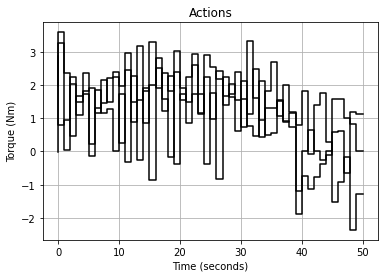

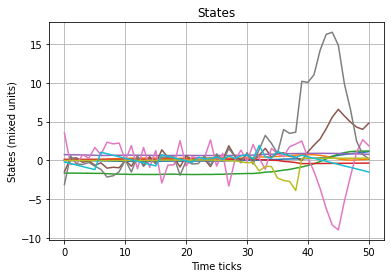

In [158]:
model_path = "/home/sgillen/work/bball/models/back_ball7/model.zip"
model = model.load(model_path)

obs_hist, act_hist, rew_hist = do_rollout_stable()


print(f"reward sum: {sum(rew_hist)}")

plt.step([i for i in range(act_hist.shape[0])], act_hist, 'k')
plt.title('Actions')
plt.xlabel('Time (seconds)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States')
plt.xlabel('Time ticks')
plt.ylabel('States (mixed units)')
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.show()